<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Sentiment analysis con Embeddings + LSTM

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [2]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers

from keras.utils.np_utils import to_categorical
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

### Datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\
Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [3]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1k2Dz4oY5uxI3JEaT6m-L2T2HvLkECYIP'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1k2Dz4oY5uxI3JEaT6m-L2T2HvLkECYIP
To: /content/clothing_ecommerce_reviews.csv
100%|██████████| 8.48M/8.48M [00:00<00:00, 38.5MB/s]


In [4]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [5]:
df.shape

(23486, 10)

### 1 - Limpieza de datos
Alumno:
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.



In [6]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


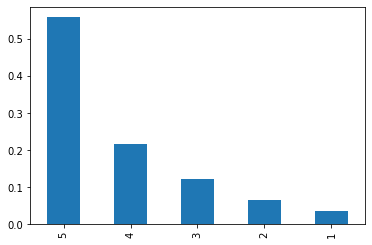

In [7]:
# Alumno: Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecot a cada clase
cuenta=df['Rating'].value_counts(5).plot(kind='bar')

Podemos observar que el dataset tiene un sesgo bastante grande hacia el número 5. Dicho esto, más adelante tendremos que tener eso en cuenta.


In [8]:
# Alumno: tomar la columna de las review y almacenarlo todo en un vector numpy de reviews
resegnas=df['Review Text']
resegnas_np=resegnas.to_numpy()

In [9]:
# Alumno: Cuantas reviews (rows) hay para evaluar?
resegnas_np.shape

(23486,)

In [10]:
# Alumno: Concatenar todas las reviews para armar el corpus
#Usamos la función map teniendo en cuenta que algunos puntos los marca como float
corpus=' '.join(map(str,resegnas_np))

In [11]:
# Alumno: ¿Cuál es la longitud de ese corpus?
print(len(corpus))

7015023


In [12]:
# Alumno: Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase
from keras.preprocessing.text import text_to_word_sequence as ttws
ttws_corpus=ttws(corpus)

In [13]:
# Alumno: Dar un vistazo a los primeros 20 tokens/palabras
print(ttws_corpus[:20])

['absolutely', 'wonderful', 'silky', 'and', 'sexy', 'and', 'comfortable', 'love', 'this', 'dress', "it's", 'sooo', 'pretty', 'i', 'happened', 'to', 'find', 'it', 'in', 'a']


In [14]:
# Alumno: ¿Cuántos tokens/palabras hay? 
len(ttws_corpus)

1373048

In [15]:
print(corpus[:20])
print(ttws_corpus[:20])

Absolutely wonderful
['absolutely', 'wonderful', 'silky', 'and', 'sexy', 'and', 'comfortable', 'love', 'this', 'dress', "it's", 'sooo', 'pretty', 'i', 'happened', 'to', 'find', 'it', 'in', 'a']


In [16]:
# Alumno: Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# num_words --> the maximum number of words to keep, based on word frequency.
# Only the most common num_words-1 words will be kept.
from keras.preprocessing.text import Tokenizer as ttkeras
num_words = 2000
vocab_size = num_words

tokenizer_keras=ttkeras(num_words=vocab_size)
tokenizer_keras.fit_on_texts(ttws_corpus)

In [17]:
# Alumno: Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario
word_index=tokenizer_keras.word_index
len(word_index)

14848

In [18]:
# Alumno: Convertir las palabras/tokens a números
secuencias_keras=tokenizer_keras.texts_to_sequences(map(str,resegnas_np))
len(secuencias_keras)

23486

In [19]:
print(secuencias_keras[:20])

[[254, 533, 918, 3, 663, 3, 68], [21, 7, 18, 33, 1714, 99, 2, 1323, 8, 221, 5, 9, 4, 106, 3, 36, 315, 2, 131, 1244, 2, 430, 41, 24, 52, 5, 136, 1244, 33, 95, 2, 72, 4, 95, 3, 38, 502, 2, 21, 1, 86, 11, 31, 417, 39, 4, 53, 455, 1, 393, 41, 155, 29, 4, 130, 1373, 11, 439, 440, 6, 773, 95], [2, 65, 313, 178, 1096, 12, 7, 18, 3, 51, 195, 5, 8, 102, 12, 31, 2, 1153, 52, 1, 95, 46, 17, 236, 22, 10, 2, 219, 7, 8, 29, 46, 16, 46, 9, 662, 20, 2, 118, 19, 785, 5, 43, 2, 5, 9, 95, 97, 82, 15, 39, 638, 251, 1, 25, 657, 15, 68, 3, 26, 259, 10, 1, 175, 657, 65, 4, 23, 148, 273, 476, 3, 528, 719, 490, 151, 976, 1877, 4, 1878, 142, 1590, 15, 1, 151, 476, 831, 314, 1, 470, 5, 689], [2, 21, 21, 21, 7, 631, 33, 284, 1303, 3, 789, 317, 183, 2, 32, 5, 2, 115, 534, 10, 34, 210], [7, 80, 6, 23, 58, 8, 75, 487, 8, 1, 1158, 156, 468, 5, 6, 1, 54, 86, 8, 32, 14, 269, 3, 5, 6, 1191, 16, 5, 832, 59, 14, 252, 396, 21, 7, 80], [2, 21, 1979, 1980, 238, 10, 7, 56, 6, 19, 12, 1, 23, 95, 2, 38, 39, 273, 266, 1025, 323,

In [20]:
# Alumno: Determinar cual es la oración más larga
max(len(s) for s in secuencias_keras)

115

In [21]:
# Alumno: Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
from keras_preprocessing.sequence import pad_sequences
maxlen = 115
X=pad_sequences(secuencias_keras,padding='pre',maxlen=maxlen)

In [22]:
# Alumno: Observar las dimensiones de la variable input

In [23]:
X.shape

(23486, 115)

In [24]:
# Alumno tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding
# Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad
# de clases que se deseen predecir (en este ejemplo son 5)
y_OHE=pd.get_dummies(df['Rating'],prefix='Rating')
Y=y_OHE.to_numpy()

In [25]:
# Alumno: Dividir los datos en train y test
from sklearn.model_selection import train_test_split
porcentaje_test=0.2
X_Train, X_Test, Y_Train, Y_Test=train_test_split(X,Y, test_size=porcentaje_test,random_state=42)

In [26]:
# Alumno: determinar la dimensiones de entrada y salida
in_shape=X_Train.shape[1]
out_shape=5 #Teniendo en cuenta que tenemos 5 clases.
print("in_shape", in_shape, ", out_shape", out_shape)

in_shape 115 , out_shape 5


### 2 - Entrenar el modelo con Embeddings + LSTM

In [27]:
# Alumno: Entrene su modelo con LSTM entrenando sus propios embeddings
# o utilizando embeddings pre-entrenados.
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout

model=Sequential()

model.add(Embedding(input_dim=vocab_size+1, output_dim=50,input_length=in_shape))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64))

model.add(Dense(units=128,activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=out_shape,activation='sigmoid'))

model.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 115, 50)           100050    
                                                                 
 lstm (LSTM)                 (None, 115, 64)           29440     
                                                                 
 dropout (Dropout)           (None, 115, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 6

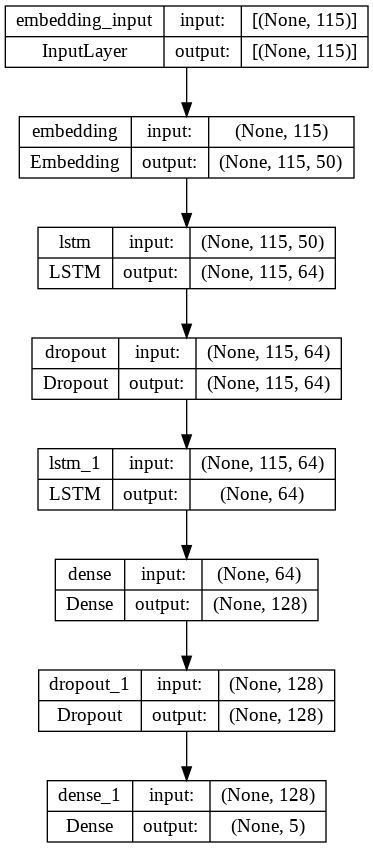

In [28]:
from keras.utils.vis_utils import plot_model
plot_model(model,to_file='ploteamos_el_modelo.png',show_shapes=True, show_layer_names=True)

In [29]:
hist=model.fit(X_Train,Y_Train,epochs=50, validation_split=porcentaje_test)

Epoch 1/50
470/470 [==============================] - 15s 15ms/step - loss: 0.4022 - accuracy: 0.5613 - val_loss: 0.3520 - val_accuracy: 0.5828
Epoch 2/50
470/470 [==============================] - 6s 13ms/step - loss: 0.3248 - accuracy: 0.6088 - val_loss: 0.3171 - val_accuracy: 0.6102
Epoch 3/50
470/470 [==============================] - 6s 14ms/step - loss: 0.2971 - accuracy: 0.6408 - val_loss: 0.3108 - val_accuracy: 0.6213
Epoch 4/50
470/470 [==============================] - 6s 13ms/step - loss: 0.2830 - accuracy: 0.6584 - val_loss: 0.3063 - val_accuracy: 0.6293
Epoch 5/50
470/470 [==============================] - 6s 14ms/step - loss: 0.2706 - accuracy: 0.6697 - val_loss: 0.3090 - val_accuracy: 0.6229
Epoch 6/50
470/470 [==============================] - 6s 14ms/step - loss: 0.2584 - accuracy: 0.6888 - val_loss: 0.3091 - val_accuracy: 0.6285
Epoch 7/50
470/470 [==============================] - 8s 16ms/step - loss: 0.2493 - accuracy: 0.7040 - val_loss: 0.3130 - val_accuracy: 0.609

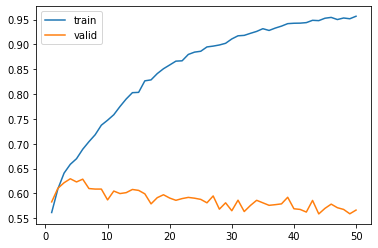

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count=range(1,len(hist.history['accuracy'])+1)
sns.lineplot(x=epoch_count, y=hist.history['accuracy'],label='train')
sns.lineplot(x=epoch_count, y=hist.history['val_accuracy'],label='valid')
plt.show()

In [31]:
model.evaluate(X_Test, Y_Test)

147/147 [==============================] - 1s 6ms/step - loss: 0.9061 - accuracy: 0.5658


[0.9060775637626648, 0.5657726526260376]

In [32]:
modelo_emb=model.predict(X_Test)

147/147 [==============================] - 2s 5ms/step


In [33]:
modelo_emb

array([[5.9844937e-05, 7.1313884e-04, 1.9459816e-03, 9.8681009e-01,
        1.0347584e-02],
       [2.2120096e-07, 6.2642157e-06, 9.3784338e-06, 1.3254490e-03,
        9.9892116e-01],
       [1.2693501e-02, 9.4976526e-01, 8.4266644e-03, 4.4935415e-03,
        1.9741407e-02],
       ...,
       [3.5186655e-05, 5.2245118e-02, 8.0927414e-01, 1.6243610e-04,
        1.0706897e-02],
       [9.0624724e-07, 3.3520631e-04, 9.6311764e-05, 9.9931574e-01,
        3.0619200e-04],
       [1.1402133e-09, 4.0540755e-08, 4.5928797e-08, 5.7860063e-05,
        9.9995315e-01]], dtype=float32)

In [34]:
np.min(modelo_emb)

7.969074e-13

In [35]:
print(X_Test.shape)

(4698, 115)


Es importante tener en cuenta que la variable modelo_emb me representa la probabilidad de que un comentario I (que hace parte del dataset de test), tenga una valoración corresponiente a cada una de nuestras 5 clases.

In [36]:
modelo_emb[:10]

array([[5.9844937e-05, 7.1313884e-04, 1.9459816e-03, 9.8681009e-01,
        1.0347584e-02],
       [2.2120096e-07, 6.2642157e-06, 9.3784338e-06, 1.3254490e-03,
        9.9892116e-01],
       [1.2693501e-02, 9.4976526e-01, 8.4266644e-03, 4.4935415e-03,
        1.9741407e-02],
       [7.9423118e-01, 3.4013122e-02, 6.8992406e-02, 4.8898723e-02,
        3.9873637e-02],
       [2.3189704e-08, 1.8737435e-07, 4.2139968e-07, 9.6279997e-05,
        9.9991560e-01],
       [1.1106504e-06, 2.0760446e-05, 1.4823399e-04, 9.3879598e-01,
        5.6247342e-02],
       [1.2292162e-03, 2.0471103e-02, 4.0270604e-02, 9.1068846e-01,
        2.6662344e-02],
       [3.0043668e-06, 1.2049485e-03, 1.8720012e-04, 9.6732652e-01,
        2.5672294e-02],
       [7.2195938e-08, 4.0710188e-07, 3.4694946e-07, 4.5836577e-04,
        9.9969912e-01],
       [2.0150926e-02, 1.6147934e-02, 5.9868649e-02, 2.5193897e-01,
        6.4869684e-01]], dtype=float32)